In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Fri Sep 26 08:09:57 PDT 2025
lutzes
/mnt/share/homes/lutzes/vivarium_research_alzheimers/verification_and_validation


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [2]:
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [3]:
locations = [
            # 'united_states_of_america',
             'brazil',
            #  'china',
            #  'germany',
            #  'israel',
            #  'japan',
            #  'spain',
            #  'sweden',
            #  'taiwan_(province_of_china)',
            #  'united_kingdom',
            ]



results_dirs = [
    'results/model5.0/model_spec/2025_09_25_09_02_38/results/',
]

artifact_dirs = ['artifacts/model5.0/' + x + '.hdf' for x in locations]
artifact_dirs

['artifacts/model5.0/brazil.hdf']

In [4]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['deaths.parquet',
 'ylls.parquet',
 'new_simulants.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'ylds.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet']

In [5]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end

# tweak final row to be named age group 95_plus
assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
age_dictionary.loc[13, 'age_group'] = '95_plus'

age_dictionary.tail()

,age_group_id,age_group_name,age_group,age_start,age_end
9,20,75 to 79,75_to_79,75.0,80.0
10,30,80 to 84,80_to_84,80.0,85.0
11,31,85 to 89,85_to_89,85.0,90.0
12,32,90 to 94,90_to_94,90.0,95.0
13,33,95 to 99,95_plus,95.0,125.0


## Verify that all simulants in the model have AD 

In [6]:
test = pd.read_parquet(results_dirs[0] + 'deaths' + '.parquet', filters=[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_dirs[0])])
test['location'] = locations[0]
test.artifact_path.unique()

array(['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model5.0/brazil.hdf'],
      dtype=object)

In [7]:
def load_df(measure):
    data = pd.DataFrame()
    data_all = pd.read_parquet(results_dirs[0] + measure + '.parquet', filters=[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_dirs[0])])
    for artifact in data_all.artifact_path.unique():
        temp = data_all[data_all.artifact_path == artifact]

        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols)['value'].sum().reset_index()
        
        temp['location'] = locations[0]
        # temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['current_year'] = temp['current_year'].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [8]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time
person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [9]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [10]:
person_time.groupby('sub_entity').value.sum()

sub_entity
alzheimers_blood_based_biomarker_state        1.868957e+08
alzheimers_disease_state                      2.329432e+08
alzheimers_mild_cognitive_impairment_state    9.935629e+07
Name: value, dtype: float64

In [11]:
person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()

sub_entity                       alzheimers_blood_based_biomarker_state  \
location current_year age_group                                           
brazil   2025         25_to_29                                 3.507187   
                      30_to_34                              2645.420945   
                      35_to_39                              3120.895277   
                      40_to_44                              3169.995893   
                      45_to_49                              9619.712526   
...                                                                 ...   
         2100         75_to_79                            455861.141684   
                      80_to_84                            496248.903491   
                      85_to_89                            453071.926078   
                      90_to_94                            252499.416838   
                      95_plus                             108369.568789   

sub_entity                       alzheimers_disease_state  \
location current_year age_group                             
brazil   2025         25_to_29                   0.000000   
                      30_to_34                 101.207392   
                      35_to_39                 120.246407   
                      40_to_44                 101.207392   
                      45_to_49                 362.242300   
...                                                   ...   
         2100         75_to_79              578171.778234   
                      80_to_84              725652.993840   
                      85_to_89              721112.188912   
                      90_to_94              505133.108830   
                      95_plus               333509.420945   

sub_entity                       alzheimers_mild_cognitive_impairment_state  
location current_year age_group                                              
brazil   2025         25_to_29                                     2.505133  
                      30_to_34                                  1534.644764  
                      35_to_39                                  1866.324435  
                      40_to_44                                  1885.363450  
                      45_to_49                                  5718.217659  
...                                                                     ...  
         2100         75_to_79                                240599.030801  
                      80_to_84                                263799.572895  
                      85_to_89                                242620.172485  
                      90_to_94                                135370.899384  
                      95_plus                                  66256.772074  

[1140 rows x 3 columns]

In [12]:
#assert np.all(person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [13]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [14]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [15]:
# assert np.all(trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [16]:
out_counts = trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_counts.columns = [c.split('_to_')[0] for c in out_counts.columns]
#out_counts

In [17]:
out_rates = out_counts / person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()
#out_rates['alzheimers_blood_based_biomarker_state'].unstack()

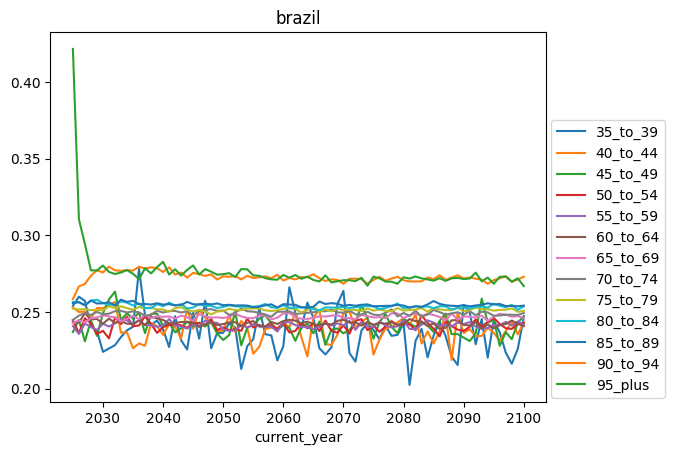

In [18]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:,2:].plot()
    plt.title(location)
    plt.legend(loc=(1.01, .01))

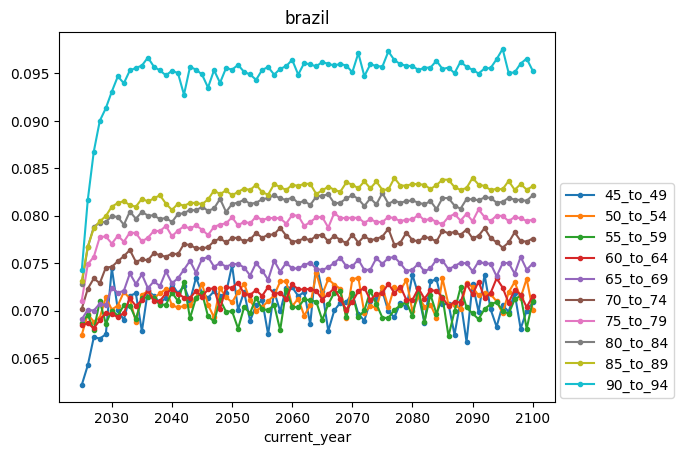

In [19]:
t = out_rates['alzheimers_blood_based_biomarker_state'].unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:,4:14].plot(marker='.')
    plt.title(location)
    plt.legend(loc=(1.01, .01))

In [20]:
# prevalence \approx incidence * duration
prevalence_count = person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()

mci_duration_est = (
    prevalence_count['alzheimers_mild_cognitive_impairment_state']
    / out_counts['alzheimers_blood_based_biomarker_state']
)
#mci_duration_est

In [21]:
new_sims = load_df('new_simulants').groupby(['location', 'current_year', 'age_group', ]).value.sum()
# new_sims


bbbm_duration_est = (
    prevalence_count['alzheimers_blood_based_biomarker_state']
    / new_sims
)
#bbbm_duration_est

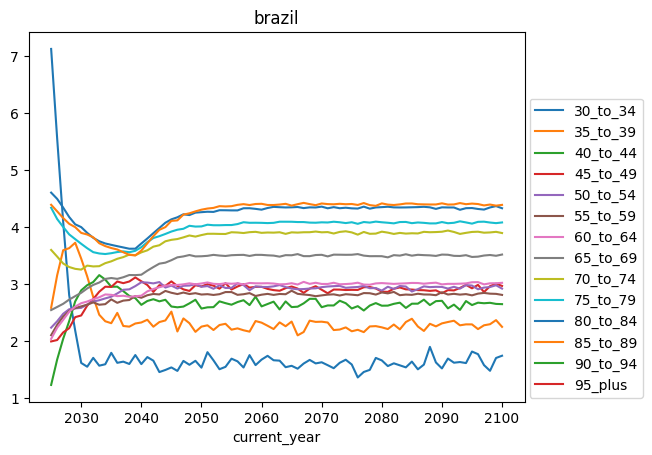

In [22]:
t = bbbm_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot()
    plt.title(location)
    plt.legend(loc=(1.01, .01))

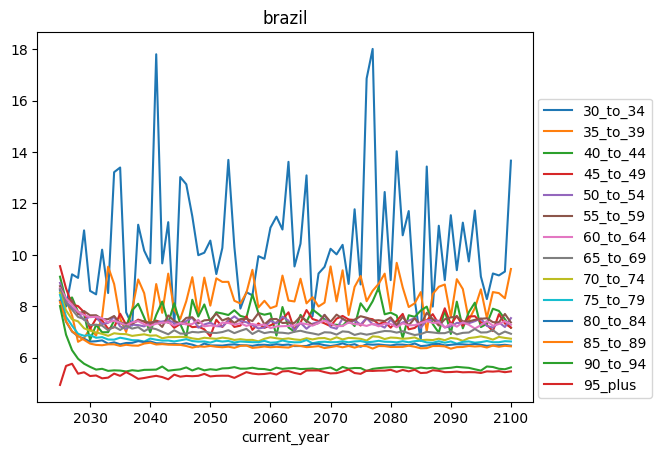

In [23]:
t = mci_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot()
    plt.title(location)
    plt.legend(loc=(1.01, .01))

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [24]:
%%time

cols = ['input_draw','current_year','location','age_group','sex']

def calculate_ocmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id'].isin(age_group_ids)]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

CPU times: user 28.3 s, sys: 4.59 s, total: 32.9 s
Wall time: 27 s


In [25]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)]
    art_ocmr = pd.concat([art_ocmr, data4])
#art_ocmr

In [26]:
art_data = art_ocmr
# location = 'United_States_Of_America'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [27]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030,2040,2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f'C{j}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.current_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                ax[i].fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                ax[i].plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(.5, .95, f"{year}", va='top', ha='center', transform=ax[i].transAxes)
#                 ax[i].tick_params(axis='x', labelrotation=90)
                
                if i == 2:
                    ax[i].set_xlabel("Age Group")
                    
                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
#                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)


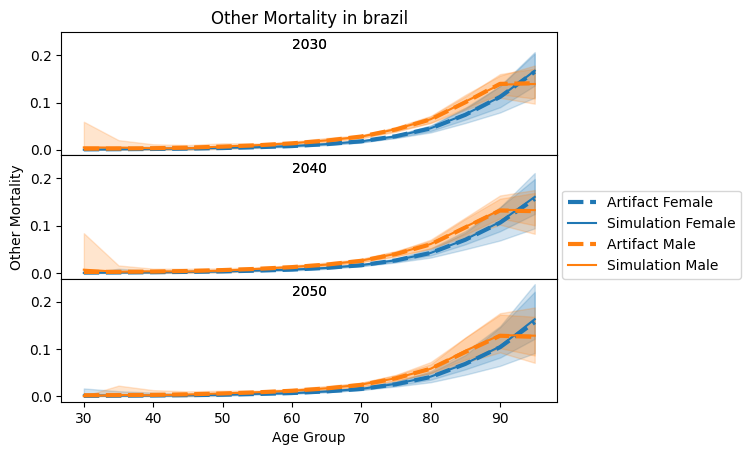

In [28]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [29]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.current_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

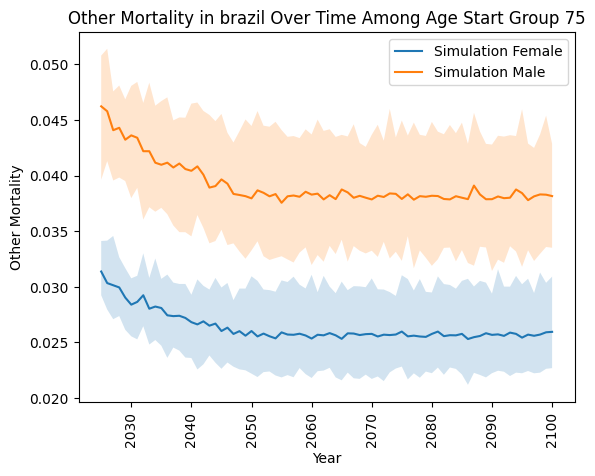

<Figure size 640x480 with 0 Axes>

In [30]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [31]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_emr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[
        person_time_total.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(infected) > 0

    deaths0 = load_df('deaths')
    deaths = deaths0.loc[
        deaths0.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr()

In [32]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)]
        out = pd.concat([out, data])
    return out

In [33]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
# art_emr

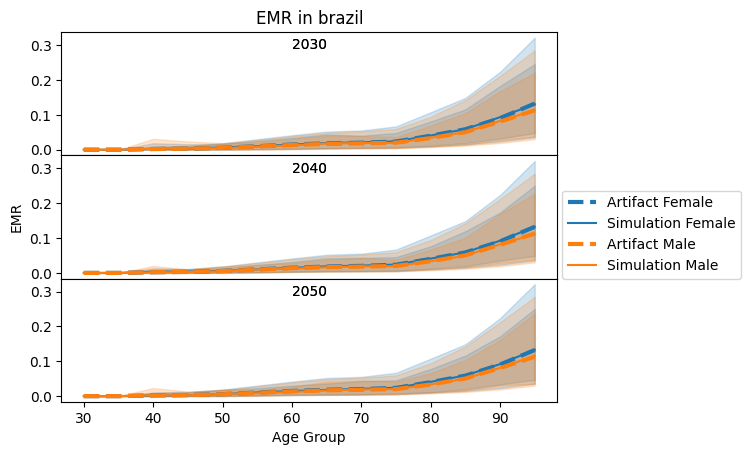

In [34]:
age_group_plot('EMR', sim_emr, art_emr, art_year=2021)

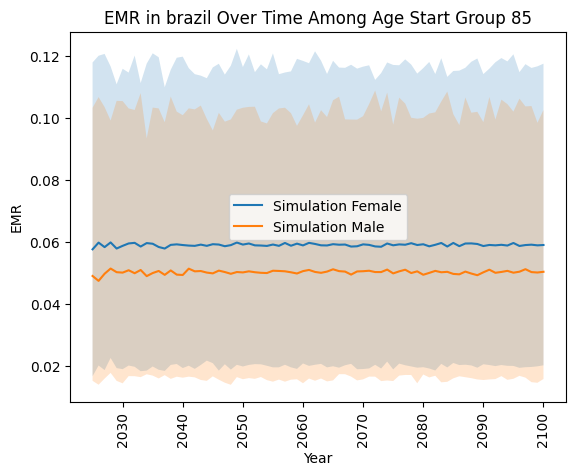

<Figure size 640x480 with 0 Axes>

In [35]:
over_time_plot('EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [36]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    # df['location'] = df.location.str.replace(' ', '_').str.lower()
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
# art_incidence_data 
    

In [37]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.lower()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2023"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean

    ratio = 100_000 / prev
    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'current_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
# scale

In [38]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
brazil,168.0,0.009168,0.0,0.009168,0.009168,0.009168,0.009168,0.009168


In [39]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('new_simulants')
# new_sims

In [40]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state']

In [41]:
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','current_year']])

In [42]:
#new_ad_dementia

In [43]:
new_sims['total_incidence'] = new_sims['value'] / new_sims['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_sims['ratio']

def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims)

In [44]:
new_ad_dementia_summary = summarize(new_ad_dementia)
#new_ad_dementia_summary

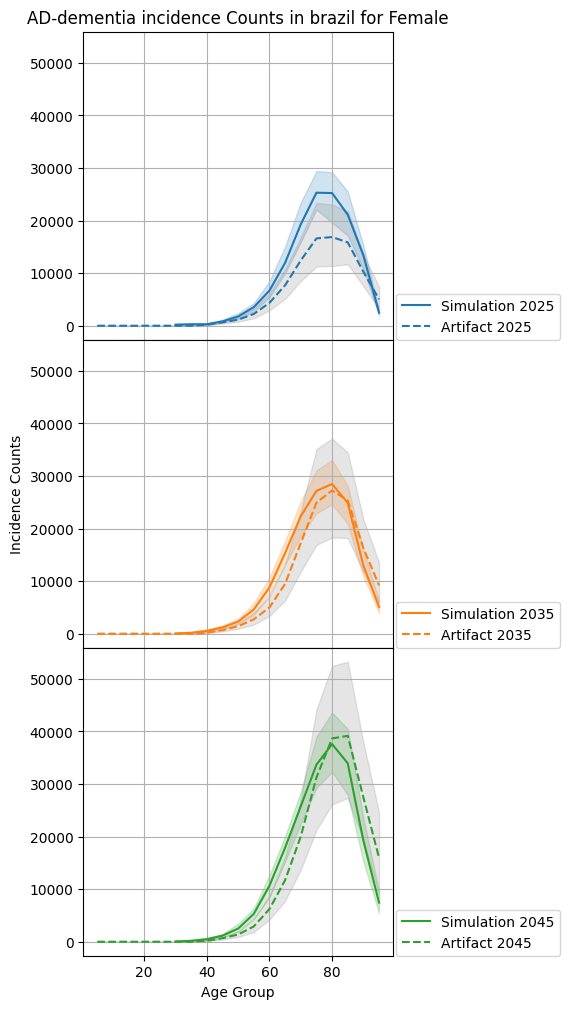

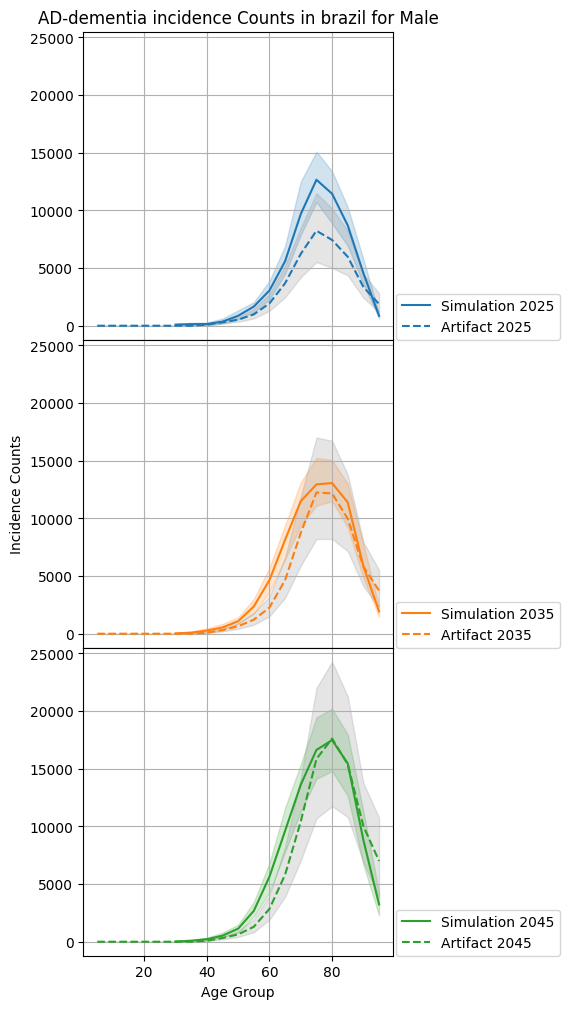

In [45]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4,12))
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query('location == @location and current_year == @year and sex == @sex')

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            ax[i].fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color='grey')
            ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)
            ax[i].plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            ax[i].grid(True)
            if i == 0:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
#             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 1:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend(loc=(1.01, 0))


I did some manual checks against GBD compare to make sure these were less than those, with the expectation they are about half. 

## Verifying Prevalence

In [46]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'population.scaling_factor'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data.head()

draw_0  draw_1  draw_2  \
sex    age_start age_end location year_start year_end                           
Female 5.0       10.0    Brazil   2021       2022         0.0     0.0     0.0   
                                  2022       2023         0.0     0.0     0.0   
                                  2023       2024         0.0     0.0     0.0   
                                  2024       2025         0.0     0.0     0.0   
                                  2025       2026         0.0     0.0     0.0   

                                                       draw_3  draw_4  draw_5  \
sex    age_start age_end location year_start year_end                           
Female 5.0       10.0    Brazil   2021       2022         0.0     0.0     0.0   
                                  2022       2023         0.0     0.0     0.0   
                                  2023       2024         0.0     0.0     0.0   
                                  2024       2025         0.0     0.0     0.0   
                                  2025       2026         0.0     0.0     0.0   

                                                       draw_6  draw_7  draw_8  \
sex    age_start age_end location year_start year_end                           
Female 5.0       10.0    Brazil   2021       2022         0.0     0.0     0.0   
                                  2022       2023         0.0     0.0     0.0   
                                  2023       2024         0.0     0.0     0.0   
                                  2024       2025         0.0     0.0     0.0   
                                  2025       2026         0.0     0.0     0.0   

                                                       draw_9  ...  draw_490  \
sex    age_start age_end location year_start year_end          ...             
Female 5.0       10.0    Brazil   2021       2022         0.0  ...       0.0   
                                  2022       2023         0.0  ...       0.0   
                                  2023       2024         0.0  ...       0.0   
                                  2024       2025         0.0  ...       0.0   
                                  2025       2026         0.0  ...       0.0   

                                                       draw_491  draw_492  \
sex    age_start age_end location year_start year_end                       
Female 5.0       10.0    Brazil   2021       2022           0.0       0.0   
                                  2022       2023           0.0       0.0   
                                  2023       2024           0.0       0.0   
                                  2024       2025           0.0       0.0   
                                  2025       2026           0.0       0.0   

                                                       draw_493  draw_494  \
sex    age_start age_end location year_start year_end                       
Female 5.0       10.0    Brazil   2021       2022           0.0       0.0   
                                  2022       2023           0.0       0.0   
                                  2023       2024           0.0       0.0   
                                  2024       2025           0.0       0.0   
                                  2025       2026           0.0       0.0   

                                                       draw_495  draw_496  \
sex    age_start age_end location year_start year_end                       
Female 5.0       10.0    Brazil   2021       2022           0.0       0.0   
                                  2022       2023           0.0       0.0   
                                  2023       2024           0.0       0.0   
                                  2024       2025           0.0       0.0   
                                  2025       2026           0.0       0.0   

                                                       draw_497  draw_498  \
sex    age_start age_end location year_start year_end                       
Female 5.0      

In [47]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
723,2048,brazil,95_plus,Male,25.0,93805.166346,25686.191559,50815.686127,57085.395217,93575.626787,144360.707639,145954.368004,33,95 to 99,95.0,125.0
724,2049,brazil,95_plus,Female,25.0,206367.430996,55881.159837,118879.630526,126067.497852,209930.322166,304406.618460,305855.996817,33,95 to 99,95.0,125.0
725,2049,brazil,95_plus,Male,25.0,97992.842334,27659.712164,51241.973879,58180.626826,97619.895203,152495.152383,155026.645803,33,95 to 99,95.0,125.0
726,2050,brazil,95_plus,Female,25.0,214444.162937,59108.538335,120967.347465,128988.115475,219068.182696,320483.131937,320633.972219,33,95 to 99,95.0,125.0
727,2050,brazil,95_plus,Male,25.0,102152.973575,29344.354048,51843.148914,59155.623428,100024.595342,160323.544382,162612.381697,33,95 to 99,95.0,125.0


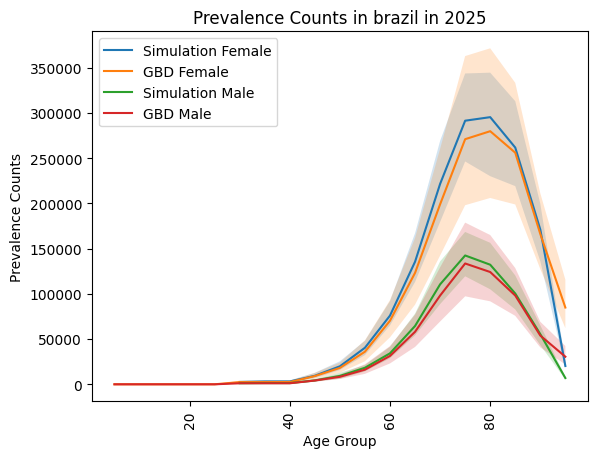

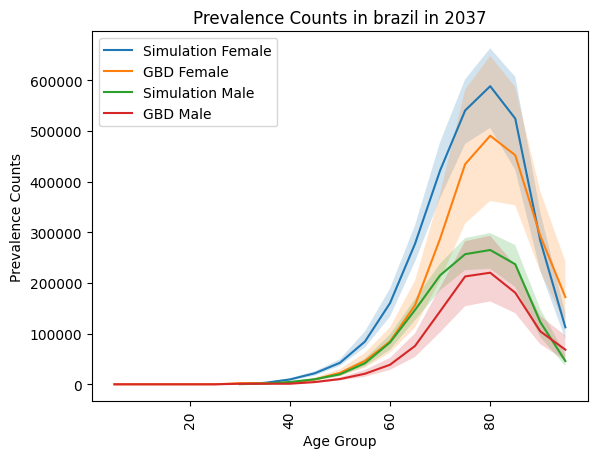

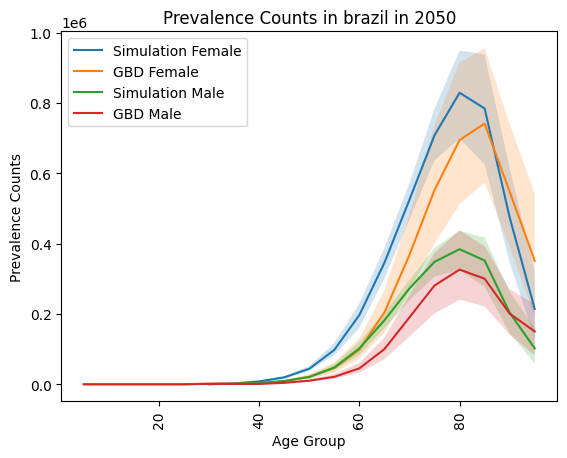

<Figure size 640x480 with 0 Axes>

In [48]:
for location in new_sims.location.unique():
    for year in [2025,2037,2050]:
        for sex in new_sims.sex.unique(): # [:1]:
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'GBD {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time

In [49]:
cols = ['input_draw','current_year','location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total.head()

,current_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,brazil,25.0,102427.572567,159.387194,102109.240246,102149.823409,102451.942505,102648.545380,102648.845996
1,2026,brazil,25.0,111362.682218,743.265325,109947.301848,110092.499384,111360.197125,112386.700616,112465.462012
2,2027,brazil,25.0,120113.935113,1421.063004,117405.084189,117492.563450,120405.232033,122056.716222,122092.188912
3,2028,brazil,25.0,128818.392115,2179.056927,124781.199179,124822.082957,129584.542094,131884.154415,132209.420945
4,2029,brazil,25.0,137467.796304,2947.093717,131961.412731,132119.837372,138603.022587,141341.033265,142166.825462


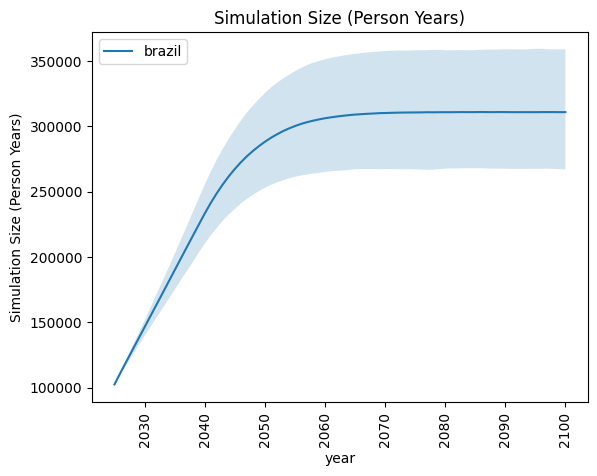

In [50]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.current_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()